In [118]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
import pandas as pd
import numpy as np
data=pd.read_csv('/content/gdrive/My Drive/attribution data.csv')

In [120]:
data

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video


In [121]:
data_path = data.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
data_path=data_path.rename(columns={"channel":"conv_path"})
sales_conv= data.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
print(data_path.shape)
print(sales_conv.shape)

(240108, 2)
(240108, 3)


In [122]:

clean_data=pd.merge(data_path,sales_conv,how='left', on = 'cookie' )
clean_data.head()

,cookie,conv_path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [123]:
def listToString(clean_data):  
    str1 = ""  
    for i in clean_data['conv_path']:
      str1 += i + ' > '    
    return str1[:-3]

clean_data['conv_path'] = clean_data.apply(listToString, axis=1)
clean_data.head()

,cookie,conv_path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [124]:
clean_data['var_null']=[abs(i-1) for i in clean_data['conversion']]

In [125]:
clean_data

,cookie,conv_path,conversion,conversion_value,var_null
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0,1
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0,1
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0,1
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0,1
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0,1
...,...,...,...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,Online Display,0,0.0,1
240104,ooooEBE0o0D97ACAAAnDoi3F0,Online Display,0,0.0,1
240105,ooooEiB0CCoEf9fiiC90Dfhfk,Online Display > Online Display > Online Display,0,0.0,1
240106,ooooiBh70D3k3BfAhDFfii9h7,Paid Search > Online Video,0,0.0,1


In [126]:
pip install ChannelAttribution

In [127]:
import ChannelAttribution
from ChannelAttribution import heuristic_models as hm


In [128]:
heuristic=hm(clean_data,"conv_path","conversion",var_value="conversion_value")

In [129]:
from ChannelAttribution import markov_model as mm
markov=mm(clean_data,"conv_path","conversion",var_value="conversion_value")

Number of simulations: 100000 - Convergence reached: 1.71% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%


In [130]:
import plotly.io as pio

In [166]:
R=pd.merge(heuristic,markov,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions","linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]
R1=pd.melt(R1, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,transforms = [dict(type = "groupby", groups = R1.variable)])]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

In [132]:
R2=R[["channel_name","first_touch_value","last_touch_value",
"linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R2=pd.melt(R2, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum", x = R2.channel_name, y = R2.value,
             transforms = [dict(type = "groupby",groups = R2.variable)])]

fig = dict({"data":data})
pio.show(fig,validate=False)


In [133]:
from ChannelAttribution import transition_matrix 
transition_matrix = transition_matrix(clean_data, "conv_path", "conversion", var_null="var_null")
transition_matrix['transition_matrix'].head()

,channel_from,channel_to,transition_probability
0,(start),1,0.119188
1,(start),3,0.317399
2,(start),4,0.278408
3,(start),5,0.142361
4,(start),2,0.142644


In [134]:
transition_matrix

{'channels':    id_channel    channel_name
 0           1       Instagram
 1           2  Online Display
 2           3     Paid Search
 3           4        Facebook
 4           5    Online Video,
 'transition_matrix':    channel_from    channel_to  transition_probability
 0       (start)             1                0.119188
 1       (start)             3                0.317399
 2       (start)             4                0.278408
 3       (start)             5                0.142361
 4       (start)             2                0.142644
 5             1             2                0.018683
 6             1        (null)                0.363772
 7             1             4                0.372522
 8             1             5                0.022247
 9             1             1                0.159586
 10            1             3                0.033351
 11            1  (conversion)                0.029840
 12            2             2                0.349007
 13       

In [135]:
matrix = pd.pivot_table(transition_matrix['transition_matrix'], values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)
matrix

channel_to,(conversion),(null),1,2,3,4,5
channel_from,,,,,,,
(start),NaN,NaN,0.119188,0.142644,0.317399,0.278408,0.142361
1,0.029840,0.363772,0.159586,0.018683,0.033351,0.372522,0.022247
2,0.030104,0.457025,0.021069,0.349007,0.077351,0.048992,0.016453
3,0.030025,0.443073,0.022656,0.041475,0.385981,0.052054,0.024736
4,0.030164,0.363108,0.159394,0.018197,0.034010,0.373140,0.021987
5,0.030079,0.280030,0.014492,0.009894,0.024677,0.034765,0.606062


In [136]:
matrix=matrix.rename(columns={'1':'Instagram','2':'Online Display','3':'Paid Search','4':'Facebook','5':'Online Video'},
              index={'1':'Instagram','2':'Online Display','3':'Paid Search','4':'Facebook','5':'Online Video'})

In [137]:
print(help(mm))

Help on built-in function markov_model in module ChannelAttribution:

markov_model(...)
    markov_model(Data, var_path, var_conv, var_value=None, var_null=None, order=1, nsim_start=1e5, max_step=None, out_more=False, sep=u'>', ncore=1, nfold=10, seed=0, conv_par=0.05, rate_step_sim=1.5, verbose=True)
    
    
    Estimate a k-order Markov model from customer journey data. Differently from markov_model, this function iterates estimation until a desidered convergence is reached and enables multiprocessing.
    
    Parameters
    ----------
    Data : DataFrame
        customer journeys.
    var_path: string
        column of Data containing paths.
    var_conv : string
        column of Data containing total conversions for each path.
    var_value : string, optional, default None
        column of Data containing revenue for each path.
    var_null : string
        column of Data containing total paths that do not lead to conversion.
    order : int, default 1
        Markov model or

In [138]:
pip install pychattr

In [139]:
from pychattr.channel_attribution import MarkovModel

In [140]:
print(help(MarkovModel))

Help on class MarkovModel in module pychattr.channel_attribution.markov:

class MarkovModel(pychattr.channel_attribution._mixins.MarkovModelMixin)
 |  MarkovModel(path_feature, conversion_feature, null_feature=None, revenue_feature=None, cost_feature=None, separator='>>>', k_order=1, n_simulations=10000, max_steps=None, return_transition_probs=True, random_state=None, loops=True)
 |  
 |  Markov channel attribution model.
 |  
 |  Parameters
 |  ----------
 |  path_feature: string; required.
 |    The name of the feature containing the paths.
 |  
 |  conversion_feature: string; required.
 |    The name of the feature indicating whether the path resulted in a
 |    conversion.
 |  
 |    NOTE: When using Markov attribution, do not pre-aggregate
 |    conversions by path as this will effect the outcome of the
 |    simulation.
 |  
 |  null_feature: string; default=None; optional.
 |    The name of the feature indicating whether the path resulted in a
 |    non-conversion.
 |  
 |    NO

In [141]:
mm1=MarkovModel(path_feature='conv_path',conversion_feature='conversion',revenue_feature='conversion_value',separator='>')
mm1.fit(clean_data)

In [142]:
removal_effect=mm1.removal_effects_

In [143]:
markov_model=removal_effect.drop(['removal_effect'],axis=1)


In [144]:
column_names=['channel_name','value_weightage']
first_touch = pd.DataFrame(columns = column_names)
last_touch = pd.DataFrame(columns = column_names)
linear_touch = pd.DataFrame(columns = column_names)

In [145]:
first_touch['channel_name']=R['channel_name']
first_touch['value_weightage']=R['first_touch_value']/R['total_conversion_value']

last_touch['channel_name']=R['channel_name']
last_touch['value_weightage']=R['last_touch_value']/R['total_conversion_value']

linear_touch['channel_name']=R['channel_name']
linear_touch['value_weightage']=R['linear_touch_value']/R['total_conversion_value']

In [146]:
first_touch['value_weightage']=first_touch['value_weightage']/first_touch['value_weightage'].sum()
last_touch['value_weightage']=last_touch['value_weightage']/last_touch['value_weightage'].sum()
linear_touch['value_weightage']=linear_touch['value_weightage']/linear_touch['value_weightage'].sum()

In [147]:
markov_model['removal_effect_value']=markov_model['removal_effect_value']/markov_model['removal_effect_value'].sum()
markov_model.rename(columns = {'removal_effect_value':'value_weightage'}, inplace = True)

 
#### Value Weightage: Percentage of revenue derieved from a particular channel 

In [148]:
first_touch

,channel_name,value_weightage
0,Instagram,0.132381
1,Online Display,0.208421
2,Paid Search,0.239033
3,Facebook,0.196553
4,Online Video,0.223613


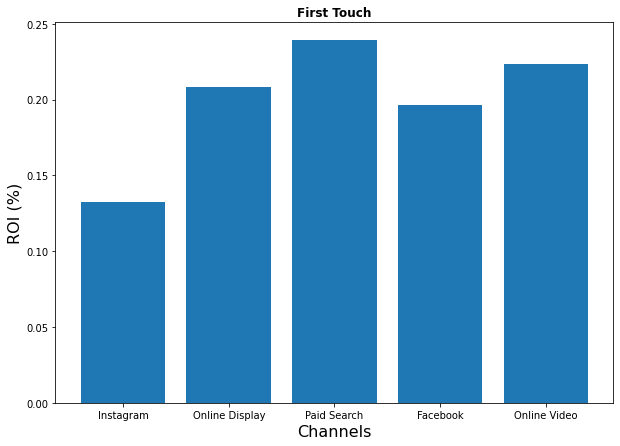

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.bar(first_touch['channel_name'],first_touch['value_weightage'])
plt.xlabel("Channels",fontsize=16)
plt.ylabel("ROI (%)",fontsize=16)
plt.title('First Touch', fontweight='bold')
plt.show()


In [150]:
linear_touch

,channel_name,value_weightage
0,Instagram,0.128704
1,Online Display,0.205142
2,Paid Search,0.234821
3,Facebook,0.198610
4,Online Video,0.232723


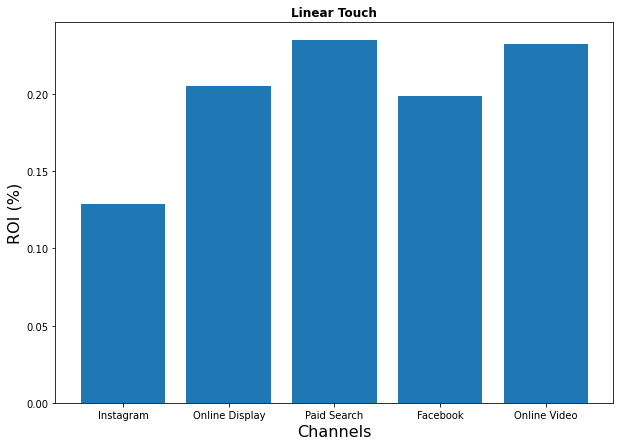

In [151]:
plt.figure(figsize=(10,7))
plt.bar(linear_touch['channel_name'],linear_touch['value_weightage'])
plt.xlabel("Channels",fontsize=16)
plt.ylabel("ROI (%)",fontsize=16)
plt.title('Linear Touch', fontweight='bold')
plt.show()


In [152]:
last_touch

,channel_name,value_weightage
0,Instagram,0.127420
1,Online Display,0.206457
2,Paid Search,0.227732
3,Facebook,0.201701
4,Online Video,0.236690


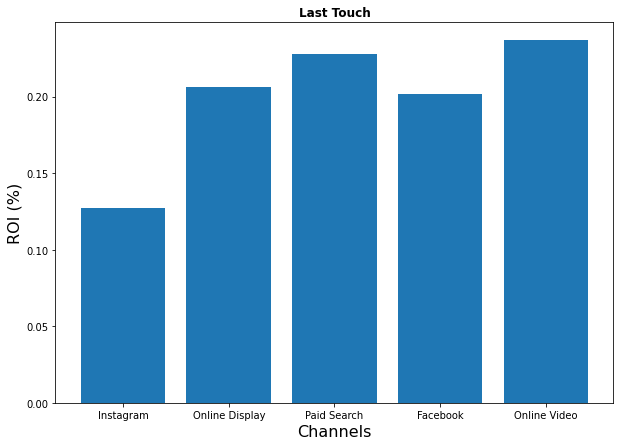

In [153]:
plt.figure(figsize=(10,7))
plt.bar(last_touch['channel_name'],last_touch['value_weightage'])
plt.xlabel("Channels",fontsize=16)
plt.ylabel("ROI (%)",fontsize=16)
plt.title('Last Touch', fontweight='bold')
plt.show()


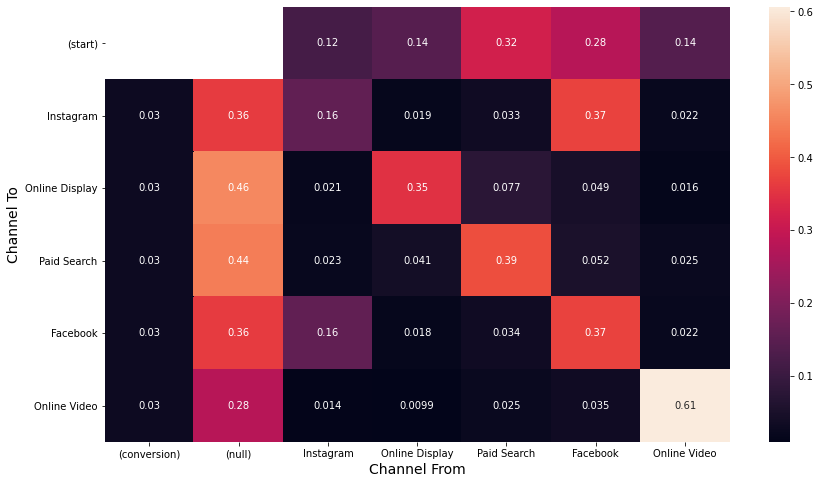

In [154]:
import seaborn as sns
fig = plt.figure(figsize = (14,8))
sns.heatmap(matrix,annot=True)
plt.xlabel("Channel From",fontsize=14)
plt.ylabel("Channel To",fontsize=14)
plt.show()

In [155]:
removal_effect

,channel_name,removal_effect,removal_effect_value
0,Instagram,0.3103,0.310868
1,Online Display,0.1813,0.179455
2,Paid Search,0.3595,0.358910
3,Facebook,0.4614,0.461955
4,Online Video,0.2489,0.249712


In [156]:
markov_model

,channel_name,value_weightage
0,Instagram,0.199159
1,Online Display,0.114969
2,Paid Search,0.229938
3,Facebook,0.295954
4,Online Video,0.159980


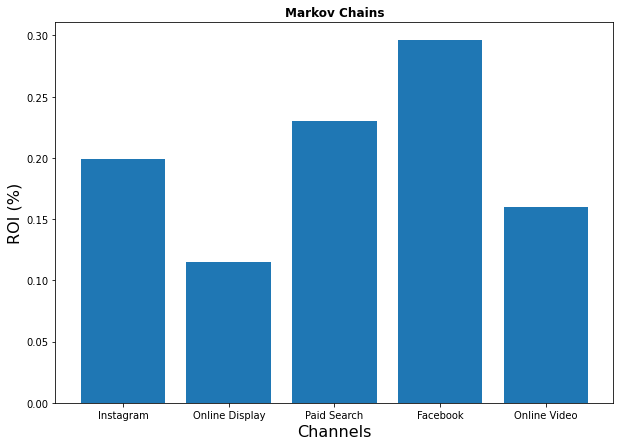

In [157]:
plt.figure(figsize=(10,7))
plt.bar(markov_model['channel_name'],markov_model['value_weightage'])
plt.xlabel("Channels",fontsize=16)
plt.ylabel("ROI (%)",fontsize=16)
plt.title('Markov Chains', fontweight='bold')
plt.show()


In [158]:
def mainMenu():
  print("Enter the amount you wish to spend on your campaign:"+'\033[0m',end="")
  amt=int(input())
  print("Select the model befitted for your campaign"+'\033[0m')
  print("1. First Touch ")
  print("2. Last Touch ")
  print("3. Linear Touch ")
  print("4. Markov Chains ")
  print("Enter the Option Number:"+'\033[0m', end="" )
  selection=int(input())
  if selection==1:
    first=first_touch.copy()
    first['value_weightage'] = first['value_weightage'].apply(lambda x: x*amt)
    first.rename(columns = {'value_weightage':'Amount to spend'}, inplace = True)
    print(first)
  if selection==2:
    last=last_touch.copy()
    last['value_weightage'] = last['value_weightage'].apply(lambda x: x*amt)
    last.rename(columns = {'value_weightage':'Amount to spend'}, inplace = True)
    print(last)
  if selection==3:
    linear=linear_touch.copy()
    linear['value_weightage'] = linear['value_weightage'].apply(lambda x: x*amt)
    linear.rename(columns = {'value_weightage':'Amount to spend'}, inplace = True)
    print(linear)
  if selection==4:
    mm2=markov_model.copy()
    mm2['value_weightage'] = mm2['value_weightage'].apply(lambda x: x*amt)
    mm2.rename(columns = {'value_weightage':'Amount to spend'}, inplace = True)
    print(mm2)

In [159]:
mainMenu()

Enter the amount you wish to spend on your campaign:500000
Select the model befitted for your campaign
1. First Touch 
2. Last Touch 
3. Linear Touch 
4. Markov Chains 
Enter the Option Number:4
     channel_name  Amount to spend
0       Instagram     99579.687812
1  Online Display     57484.475071
2     Paid Search    114968.950141
3        Facebook    147977.023616
4    Online Video     79989.863360


In [242]:
a=pd.merge(first_touch,last_touch,on="channel_name",how="inner")
a=a.rename(columns={"value_weightage_x":"first_touch","value_weightage_y":"last_touch"})
b=pd.merge(a,linear_touch,on="channel_name",how="inner")
b=b.rename(columns={"value_weightage":"linear_touch"})
c=pd.merge(b,markov_model,on="channel_name",how="inner")
c=c.rename(columns={"value_weightage":"markov_chain"})
c=pd.melt(c, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum",x = c.channel_name, y = c.value,transforms = [dict(type = "groupby", groups = c.variable)])]
fig = dict({"data":data})
pio.show(fig,validate=False)